C:\Users\koishikawa\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Bayesian optimization iteration : 1 / 8
Best score : -0.00021709870093244987
Bayesian optimization iteration : 2 / 8
Best score : -0.00021709870093244987
Bayesian optimization iteration : 3 / 8
Best score : 0.0005145550933247645
Bayesian optimization iteration : 4 / 8
Best score : 0.0005145550933247645
Bayesian optimization iteration : 5 / 8
Best score : 0.0005145550933247645
Bayesian optimization iteration : 6 / 8
Best score : 0.0005145550933247645
Bayesian optimization iteration : 7 / 8
Best score : 0.002338504133475805
Bayesian optimization iteration : 8 / 8
Best score : 0.002338504133475805


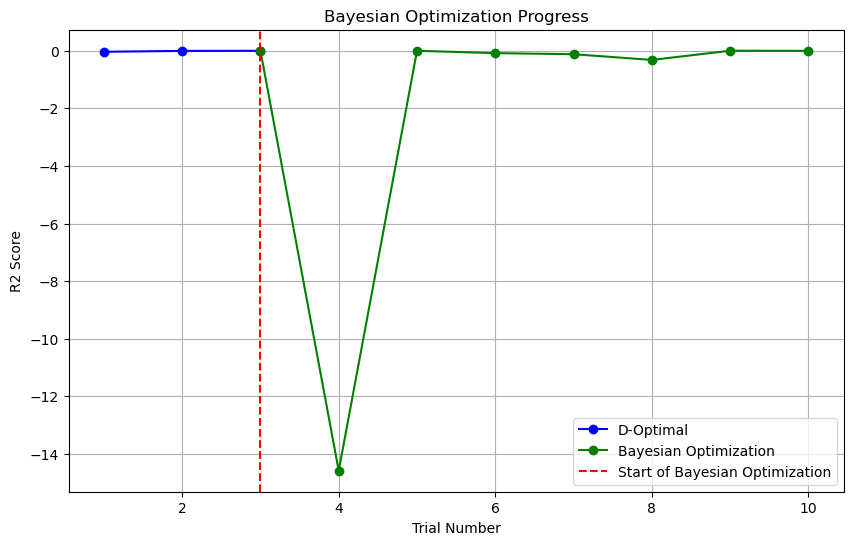

In [1]:
import pandas as pd
from bo_lstm_multiple_acquisition_function import bo_lstm_hyperparams
from sklearn.model_selection import train_test_split
#データセットの読み込み
dataset = pd.read_csv('sample_dataset.csv', index_col=0)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, shuffle=False)

(model, optimal_window_size, optimal_batch_size, optimal_learning_rate) = bo_lstm_hyperparams(train_dataset,num_epochs = 10, 
                                                                                              bo_iteration_number=8, display_flag=True, bo_iteration_plot=True)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

seq_length = int(optimal_window_size)
hidden_dim = int(optimal_hidden_dim)
output_dim = 1
batch_size = int(optimal_batch_size)
num_epochs = 100
use_attention = optimal_attention  # Attention層を使うかどうかを選択 (True or False)
fold_number = 5  # N-fold CV の N


# -------------------------------
# データ読み込みと前処理（変更なし）
# -------------------------------

dataset = pd.read_csv('sample_dataset.csv', index_col=0)

data = dataset.values.astype('float32')

inputs = data[:, 1:]
targets = data[:, 0]

#ここで入力の次元が決まります
input_dim = dataset.shape[1] - 1

def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(xs), np.array(ys)

input_sequences, target_sequences = create_sequences(inputs, targets, seq_length)

X_train, X_test, y_train, y_test = train_test_split(
    input_sequences, target_sequences, test_size=0.3, shuffle=False)

train_inputs_tensor = torch.tensor(X_train).float()
train_targets_tensor = torch.tensor(y_train).float().unsqueeze(1)

test_inputs_tensor = torch.tensor(X_test).float()
test_targets_tensor = torch.tensor(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(train_inputs_tensor, train_targets_tensor)
test_dataset = TensorDataset(test_inputs_tensor, test_targets_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = LSTMWithOptionalAttention(input_dim, hidden_dim, output_dim, use_attention, optimal_dropout_rate)

# -------------------------------
# 学習準備（変更なし）
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=optimal_learning_rate)

# -------------------------------
# モデル学習（Attentionの重みは必要に応じて取得）
# -------------------------------
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# -------------------------------
# モデル評価（Attentionの重みは必要に応じて保存）
# -------------------------------
model.eval()
test_loss = 0
all_test_predictions = []
all_true_test_targets = []
all_attention_weights = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs, attention_weights = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

        all_test_predictions.extend(outputs.cpu().numpy().flatten())
        all_true_test_targets.extend(targets.cpu().numpy().flatten())
        if use_attention:
            all_attention_weights.extend(attention_weights.cpu().numpy())

average_test_loss = test_loss / len(test_dataset)
r2 = r2_score(all_true_test_targets, all_test_predictions)
#r2 = r2lm(all_true_test_targets, all_test_predictions)
mae = mean_absolute_error(all_true_test_targets, all_test_predictions)
rmse = np.sqrt(mean_squared_error(all_true_test_targets, all_test_predictions))

print(f'\n平均テスト損失: {average_test_loss:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# -------------------------------
# プロット（Attentionの可視化はuse_attentionがTrueの場合のみ）
# -------------------------------
# 学習曲線（変更なし）
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# テスト結果（変更なし）
plt.figure(figsize=(12, 6))
plt.plot(all_true_test_targets, label='Actual')
plt.plot(all_test_predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()